# Pharma and Tech Sector Equity Research Project

**Python, Excel, Equity Valuation, Portfolio Analytics**

This project implements comprehensive equity research analysis including:
- Bottom-up valuation models (DCF, Comparable Company, Residual Income)
- Profitability and capital efficiency analysis
- Market positioning assessment
- CAPM and Fama-French factor analysis
- Price targets and scenario-based valuations
- Portfolio stress testing dashboard


In [1]:
# Install required packages
%pip install --quiet yfinance pandas numpy matplotlib seaborn plotly openpyxl scipy statsmodels
print("✓ All packages installed successfully!")


Note: you may need to restart the kernel to use updated packages.
✓ All packages installed successfully!


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


In [3]:
# Define universe of stocks: Pharma and Tech companies
pharma_companies = {
    'JNJ': 'Johnson & Johnson',
    'PFE': 'Pfizer',
    'MRK': 'Merck & Co.',
    'ABBV': 'AbbVie',
    'TMO': 'Thermo Fisher Scientific',
    'ABT': 'Abbott Laboratories',
    'DHR': 'Danaher Corporation',
    'LLY': 'Eli Lilly',
    'BMY': 'Bristol-Myers Squibb',
    'AMGN': 'Amgen'
}

tech_companies = {
    'AAPL': 'Apple',
    'MSFT': 'Microsoft',
    'GOOGL': 'Alphabet',
    'NVDA': 'NVIDIA',
    'META': 'Meta',
    'AMZN': 'Amazon',
    'TSLA': 'Tesla',
    'NFLX': 'Netflix',
    'AVGO': 'Broadcom',
    'AMD': 'AMD'
}

all_companies = {**pharma_companies, **tech_companies}

print(f"Pharma Companies: {len(pharma_companies)}")
print(f"Tech Companies: {len(tech_companies)}")
print(f"Total Companies: {len(all_companies)}")


Pharma Companies: 10
Tech Companies: 10
Total Companies: 20


In [4]:
# Fetch historical price data and company information
start_date = '2019-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

print("Fetching market data and company information...")

stock_data = {}
company_info = {}

for ticker, name in all_companies.items():
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date, end=end_date)
        info = stock.info
        
        if not hist.empty:
            stock_data[ticker] = {
                'name': name,
                'history': hist,
                'info': info
            }
            company_info[ticker] = {
                'name': name,
                'sector': 'Pharma' if ticker in pharma_companies else 'Tech',
                'market_cap': info.get('marketCap', None),
                'enterprise_value': info.get('enterpriseValue', None),
                'revenue': info.get('totalRevenue', None),
                'ebitda': info.get('ebitda', None),
                'net_income': info.get('netIncomeToCommon', None),
                'pe_ratio': info.get('trailingPE', None),
                'forward_pe': info.get('forwardPE', None),
                'ev_ebitda': info.get('enterpriseToEbitda', None),
                'ev_revenue': info.get('enterpriseToRevenue', None),
                'roe': info.get('returnOnEquity', None),
                'roa': info.get('returnOnAssets', None),
                'profit_margin': info.get('profitMargins', None),
                'beta': info.get('beta', None),
                'current_price': info.get('currentPrice', None)
            }
            print(f"✓ {name} ({ticker})")
    except Exception as e:
        print(f"✗ {name} ({ticker}): {str(e)}")

print(f"\nSuccessfully fetched data for {len(stock_data)} companies")


Fetching market data and company information...
✓ Johnson & Johnson (JNJ)
✓ Pfizer (PFE)
✓ Merck & Co. (MRK)
✓ AbbVie (ABBV)
✓ Thermo Fisher Scientific (TMO)
✓ Abbott Laboratories (ABT)
✓ Danaher Corporation (DHR)
✓ Eli Lilly (LLY)
✓ Bristol-Myers Squibb (BMY)
✓ Amgen (AMGN)
✓ Apple (AAPL)
✓ Microsoft (MSFT)
✓ Alphabet (GOOGL)
✓ NVIDIA (NVDA)
✓ Meta (META)
✓ Amazon (AMZN)
✓ Tesla (TSLA)
✓ Netflix (NFLX)
✓ Broadcom (AVGO)
✓ AMD (AMD)

Successfully fetched data for 20 companies


## 1. Profitability and Capital Efficiency Analysis


In [5]:
# Create comprehensive metrics dataframe
metrics_df = pd.DataFrame(company_info).T

# Calculate additional profitability and efficiency metrics
for ticker in stock_data.keys():
    if ticker in metrics_df.index:
        info = stock_data[ticker]['info']
        hist = stock_data[ticker]['history']
        
        # Calculate additional metrics
        market_cap = info.get('marketCap', None)
        enterprise_value = info.get('enterpriseValue', None)
        revenue = info.get('totalRevenue', None)
        ebitda = info.get('ebitda', None)
        net_income = info.get('netIncomeToCommon', None)
        total_assets = info.get('totalAssets', None)
        total_equity = info.get('totalStockholderEquity', None)
        debt = info.get('totalDebt', None)
        operating_cash_flow = info.get('operatingCashflow', None)
        
        # EBITDA Margin
        if revenue and ebitda:
            metrics_df.loc[ticker, 'EBITDA_Margin'] = (ebitda / revenue) * 100
        
        # Net Margin
        if revenue and net_income:
            metrics_df.loc[ticker, 'Net_Margin'] = (net_income / revenue) * 100
        
        # ROIC (Return on Invested Capital)
        if ebitda and total_assets and debt:
            invested_capital = total_assets - info.get('totalCurrentLiabilities', 0)
            if invested_capital > 0:
                metrics_df.loc[ticker, 'ROIC'] = (ebitda / invested_capital) * 100
        
        # Asset Turnover
        if revenue and total_assets:
            metrics_df.loc[ticker, 'Asset_Turnover'] = revenue / total_assets
        
        # Debt to Equity
        if debt and total_equity:
            metrics_df.loc[ticker, 'Debt_to_Equity'] = debt / total_equity
        
        # Cash Flow to Revenue
        if operating_cash_flow and revenue:
            metrics_df.loc[ticker, 'CF_to_Revenue'] = (operating_cash_flow / revenue) * 100
        
        # Price to Book
        if market_cap and total_equity:
            shares_outstanding = info.get('sharesOutstanding', None)
            if shares_outstanding:
                book_value_per_share = total_equity / shares_outstanding
                current_price = info.get('currentPrice', None)
                if current_price and book_value_per_share > 0:
                    metrics_df.loc[ticker, 'Price_to_Book'] = current_price / book_value_per_share

# Display key metrics
display_metrics = ['name', 'sector', 'market_cap', 'revenue', 'roe', 'roa', 
                   'profit_margin', 'EBITDA_Margin', 'ROIC', 'pe_ratio', 'ev_ebitda']

available_metrics = [m for m in display_metrics if m in metrics_df.columns]
print("\n=== Profitability & Capital Efficiency Metrics ===\n")
print(metrics_df[available_metrics].round(2))



=== Profitability & Capital Efficiency Metrics ===

                           name  sector     market_cap       revenue      roe  \
JNJ           Johnson & Johnson  Pharma   481859010560   92148998144  0.33619   
PFE                      Pfizer  Pharma   144701259776   62784999424  0.10598   
MRK                 Merck & Co.  Pharma   240861249536   64234999808  0.39485   
ABBV                     AbbVie  Pharma   413338206208   59643998208  1.37961   
TMO    Thermo Fisher Scientific  Pharma   216419123200   43735998464  0.13117   
ABT         Abbott Laboratories  Pharma   226259664896   43842998272   0.3062   
DHR         Danaher Corporation  Pharma   161476788224   24267999232  0.06843   
LLY                   Eli Lilly  Pharma   923395358720   59419799552   0.9647   
BMY        Bristol-Myers Squibb  Pharma    95802540032   48034000896  0.33777   
AMGN                      Amgen  Pharma   185231949824   35970998272   0.8171   
AAPL                      Apple    Tech  3968913899520  

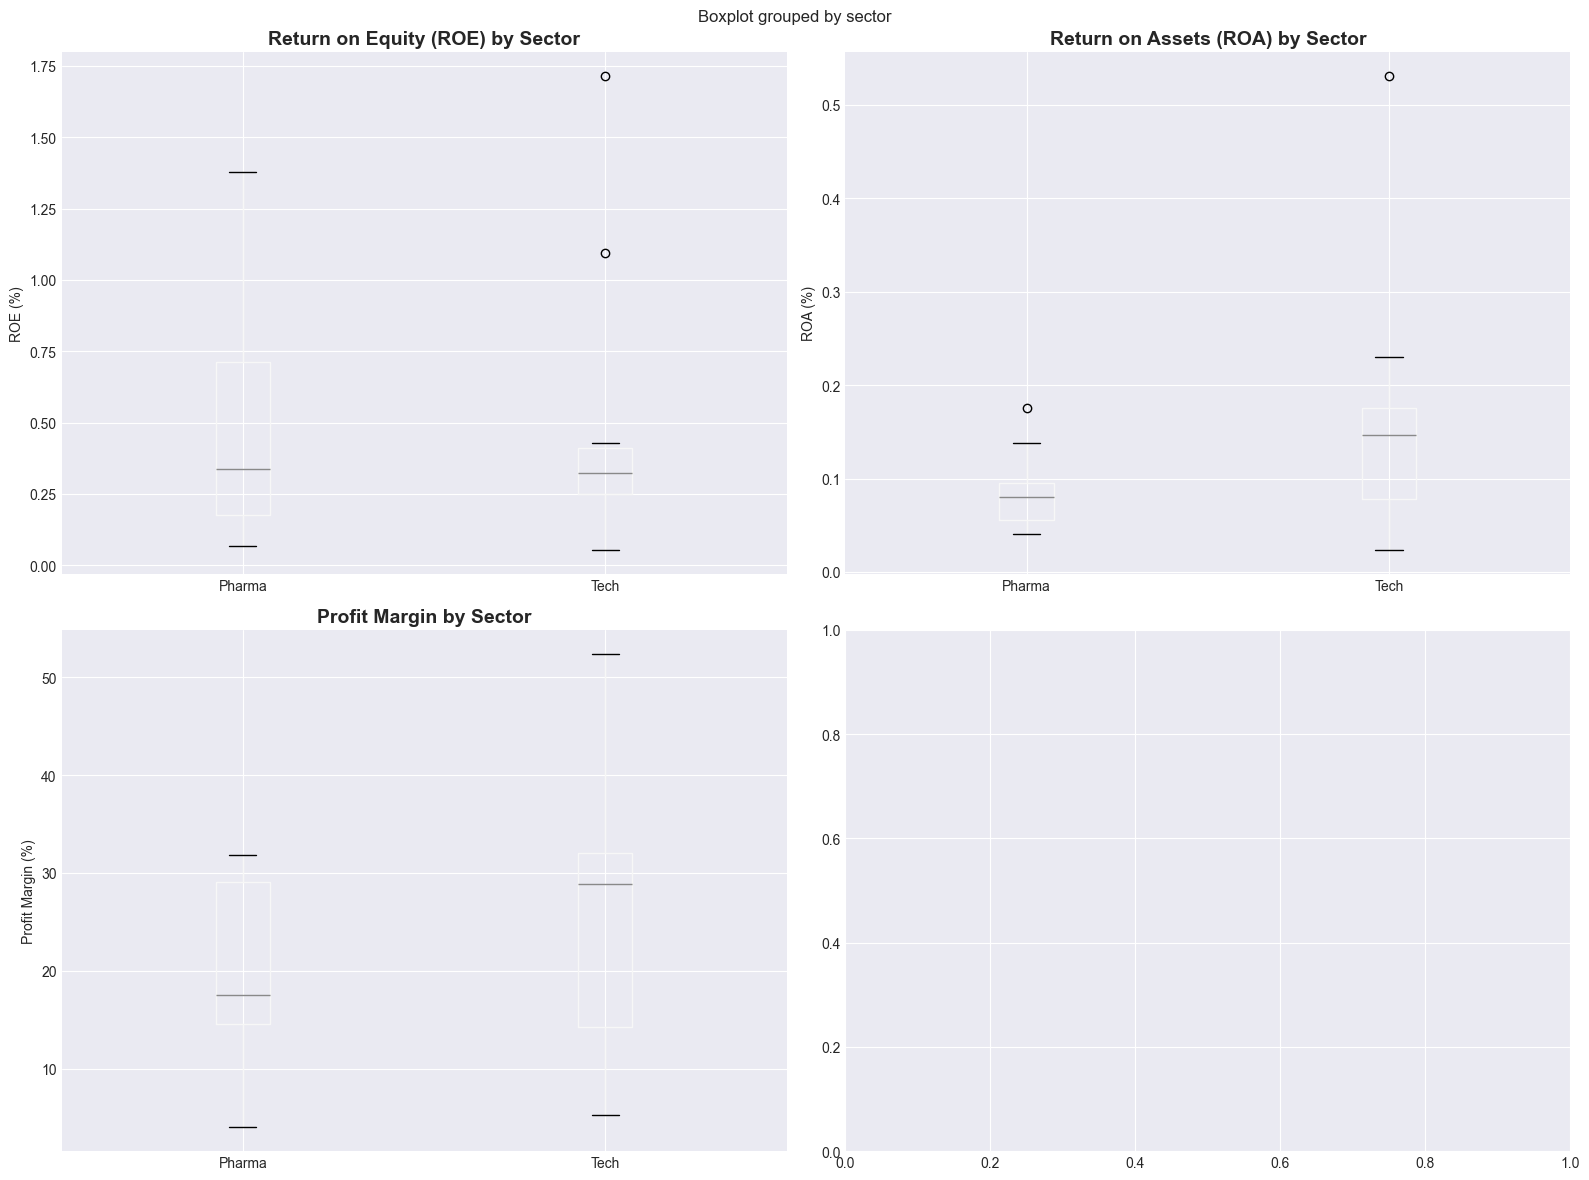

In [6]:
# Visualize profitability metrics by sector
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ROE Comparison
roe_data = metrics_df[['sector', 'roe']].dropna()
if not roe_data.empty:
    roe_data.boxplot(column='roe', by='sector', ax=axes[0, 0])
    axes[0, 0].set_title('Return on Equity (ROE) by Sector', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('')
    axes[0, 0].set_ylabel('ROE (%)')

# ROA Comparison
roa_data = metrics_df[['sector', 'roa']].dropna()
if not roa_data.empty:
    roa_data.boxplot(column='roa', by='sector', ax=axes[0, 1])
    axes[0, 1].set_title('Return on Assets (ROA) by Sector', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('ROA (%)')

# Profit Margin Comparison
margin_data = metrics_df[['sector', 'profit_margin']].dropna()
if not margin_data.empty and 'profit_margin' in margin_data.columns:
    margin_data['profit_margin_pct'] = margin_data['profit_margin'] * 100
    margin_data.boxplot(column='profit_margin_pct', by='sector', ax=axes[1, 0])
    axes[1, 0].set_title('Profit Margin by Sector', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('')
    axes[1, 0].set_ylabel('Profit Margin (%)')

# ROIC Comparison (if available)
if 'ROIC' in metrics_df.columns:
    roic_data = metrics_df[['sector', 'ROIC']].dropna()
    if not roic_data.empty:
        roic_data.boxplot(column='ROIC', by='sector', ax=axes[1, 1])
        axes[1, 1].set_title('Return on Invested Capital (ROIC) by Sector', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('')
        axes[1, 1].set_ylabel('ROIC (%)')

plt.tight_layout()
plt.show()


## 2. Comparable Company Analysis (Comps)


In [7]:
def calculate_comps_valuation(metrics_df, sector=None):
    """Calculate valuation multiples for comparable company analysis"""
    
    # Filter by sector if specified
    comps_df = metrics_df[metrics_df['sector'] == sector] if sector else metrics_df.copy()
    
    # Calculate valuation multiples
    valuation_multiples = {}
    
    # P/E multiples
    pe_ratios = comps_df['pe_ratio'].dropna()
    if len(pe_ratios) > 0:
        valuation_multiples['P/E'] = {
            'mean': pe_ratios.mean(),
            'median': pe_ratios.median(),
            'min': pe_ratios.min(),
            'max': pe_ratios.max()
        }
    
    # Forward P/E
    forward_pe = comps_df['forward_pe'].dropna()
    if len(forward_pe) > 0:
        valuation_multiples['Forward P/E'] = {
            'mean': forward_pe.mean(),
            'median': forward_pe.median(),
            'min': forward_pe.min(),
            'max': forward_pe.max()
        }
    
    # EV/EBITDA
    ev_ebitda = comps_df['ev_ebitda'].dropna()
    if len(ev_ebitda) > 0:
        valuation_multiples['EV/EBITDA'] = {
            'mean': ev_ebitda.mean(),
            'median': ev_ebitda.median(),
            'min': ev_ebitda.min(),
            'max': ev_ebitda.max()
        }
    
    # EV/Revenue
    ev_revenue = comps_df['ev_revenue'].dropna()
    if len(ev_revenue) > 0:
        valuation_multiples['EV/Revenue'] = {
            'mean': ev_revenue.mean(),
            'median': ev_revenue.median(),
            'min': ev_revenue.min(),
            'max': ev_revenue.max()
        }
    
    return pd.DataFrame(valuation_multiples).T

# Calculate comps for each sector
pharma_comps = calculate_comps_valuation(metrics_df, sector='Pharma')
tech_comps = calculate_comps_valuation(metrics_df, sector='Tech')
all_comps = calculate_comps_valuation(metrics_df)

print("=== Pharma Sector Valuation Multiples ===")
print(pharma_comps.round(2))
print("\n=== Tech Sector Valuation Multiples ===")
print(tech_comps.round(2))


=== Pharma Sector Valuation Multiples ===
              mean  median    min     max
P/E          41.39   22.96  12.76  178.53
Forward P/E  20.25   19.07   6.69   45.46
EV/EBITDA    16.80   16.05   6.78   33.24
EV/Revenue    6.41    5.61   2.72   16.07

=== Tech Sector Valuation Multiples ===
              mean  median    min     max
P/E          75.31   41.92  26.47  280.59
Forward P/E  42.98   34.61   4.80  123.84
EV/EBITDA    37.87   25.48   5.17  123.78
EV/Revenue   10.86   10.48   2.83   26.40


In [8]:
# Apply comps analysis to derive price targets
def apply_comps_valuation(ticker, metrics_df, comps_multiple='median', sector_filter=True):
    """Apply comparable company multiples to derive price target"""
    
    if ticker not in metrics_df.index:
        return None
    
    company_data = metrics_df.loc[ticker]
    sector = company_data['sector']
    
    # Get sector-specific multiples
    if sector_filter:
        comps = calculate_comps_valuation(metrics_df, sector=sector)
    else:
        comps = calculate_comps_valuation(metrics_df)
    
    price_targets = {}
    
    # P/E method
    if 'P/E' in comps.index and pd.notna(company_data.get('forward_pe', None)):
        eps = company_data['current_price'] / company_data['forward_pe'] if company_data.get('forward_pe', None) else None
        if eps and eps > 0:
            pe_multiple = comps.loc['P/E', comps_multiple]
            price_targets['P/E Method'] = eps * pe_multiple
    
    # EV/EBITDA method
    if 'EV/EBITDA' in comps.index and pd.notna(company_data.get('enterprise_value', None)):
        ebitda = company_data['enterprise_value'] / company_data['ev_ebitda'] if company_data.get('ev_ebitda', None) else None
        if ebitda:
            ev_ebitda_multiple = comps.loc['EV/EBITDA', comps_multiple]
            implied_ev = ebitda * ev_ebitda_multiple
            net_debt = company_data.get('enterprise_value', 0) - company_data.get('market_cap', 0)
            implied_market_cap = implied_ev - net_debt
            
            # Get shares outstanding
            if ticker in stock_data:
                shares = stock_data[ticker]['info'].get('sharesOutstanding', None)
                if shares and shares > 0:
                    price_targets['EV/EBITDA Method'] = implied_market_cap / shares
    
    # EV/Revenue method
    if 'EV/Revenue' in comps.index and pd.notna(company_data.get('revenue', None)):
        ev_revenue_multiple = comps.loc['EV/Revenue', comps_multiple]
        implied_ev = company_data['revenue'] * ev_revenue_multiple
        net_debt = company_data.get('enterprise_value', 0) - company_data.get('market_cap', 0)
        implied_market_cap = implied_ev - net_debt
        
        if ticker in stock_data:
            shares = stock_data[ticker]['info'].get('sharesOutstanding', None)
            if shares and shares > 0:
                price_targets['EV/Revenue Method'] = implied_market_cap / shares
    
    return price_targets

# Calculate price targets for all companies
comps_price_targets = {}
for ticker in metrics_df.index:
    targets = apply_comps_valuation(ticker, metrics_df, comps_multiple='median')
    if targets:
        comps_price_targets[ticker] = targets

comps_targets_df = pd.DataFrame(comps_price_targets).T
comps_targets_df['Current_Price'] = metrics_df['current_price']
comps_targets_df['Name'] = metrics_df['name']

# Calculate average target price
comps_targets_df['Avg_Target_Price'] = comps_targets_df.drop(['Current_Price', 'Name'], axis=1).mean(axis=1)
comps_targets_df['Upside_Downside_%'] = ((comps_targets_df['Avg_Target_Price'] - comps_targets_df['Current_Price']) / comps_targets_df['Current_Price']) * 100

print("\n=== Comparable Company Analysis - Price Targets ===\n")
display_cols = ['Name', 'Current_Price'] + [col for col in comps_targets_df.columns if col not in ['Name', 'Current_Price', 'Upside_Downside_%']] + ['Avg_Target_Price', 'Upside_Downside_%']
display_cols = [col for col in display_cols if col in comps_targets_df.columns]
print(comps_targets_df[display_cols].round(2))



=== Comparable Company Analysis - Price Targets ===

                           Name Current_Price  P/E Method  EV/EBITDA Method  \
JNJ           Johnson & Johnson         200.0      243.43            201.30   
PFE                      Pfizer         25.45       67.29             60.72   
MRK                 Merck & Co.         96.43      215.87            195.05   
ABBV                     AbbVie        233.87      278.56            232.23   
TMO    Thermo Fisher Scientific        576.03      539.44            376.87   
ABT         Abbott Laboratories         130.0      118.50            105.33   
DHR         Danaher Corporation        225.51      192.45            152.85   
LLY                   Eli Lilly       1030.05      520.38            479.72   
BMY        Bristol-Myers Squibb         47.06      161.44            134.48   
AMGN                      Amgen        343.99      474.68            407.28   
AAPL                      Apple        267.44      348.32            246.83  

## 3. Residual Income Model (RIM)


In [9]:
def residual_income_model(ticker, metrics_df, rf_rate=0.04, terminal_growth=0.03, forecast_years=5):
    """
    Residual Income Model (RIM) for equity valuation
    Based on: Value = Book Value + Sum of Residual Income PV
    
    Residual Income = Net Income - (Cost of Equity × Book Value)
    """
    
    if ticker not in metrics_df.index or ticker not in stock_data:
        return None
    
    company_data = metrics_df.loc[ticker]
    info = stock_data[ticker]['info']
    
    # Get required inputs
    current_price = company_data.get('current_price')
    book_value_per_share = info.get('bookValue', None)
    shares_outstanding = info.get('sharesOutstanding', None)
    net_income = info.get('netIncomeToCommon', None)
    beta = company_data.get('beta', 1.0)
    
    if not all([current_price, book_value_per_share, shares_outstanding, net_income]):
        return None
    
    # Calculate EPS and BVPS
    eps_current = net_income / shares_outstanding
    bvps_current = book_value_per_share
    
    # Estimate Cost of Equity using CAPM (will refine later)
    market_risk_premium = 0.06  # 6% market risk premium
    cost_of_equity = rf_rate + beta * market_risk_premium
    
    # Estimate ROE
    roe = company_data.get('roe', None)
    if not roe or pd.isna(roe):
        roe = eps_current / bvps_current if bvps_current > 0 else 0.10
    else:
        roe = roe / 100  # Convert from percentage
    
    # Forecast residual income for next N years
    # Assume ROE converges to cost of equity over time
    rim_results = []
    bvps = bvps_current
    
    for year in range(1, forecast_years + 1):
        # Assume ROE mean reverts to cost of equity
        forecast_roe = roe + (cost_of_equity - roe) * (year / forecast_years)
        forecast_roe = max(forecast_roe, cost_of_equity)  # ROE >= Cost of Equity
        
        # Forecast net income and book value
        net_income_forecast = bvps * forecast_roe
        eps_forecast = net_income_forecast / shares_outstanding if shares_outstanding > 0 else net_income_forecast
        
        # Residual income
        residual_income = net_income_forecast - (bvps * cost_of_equity)
        
        # PV of residual income
        pv_residual_income = residual_income / ((1 + cost_of_equity) ** year)
        
        rim_results.append({
            'Year': year,
            'BVPS': bvps,
            'ROE': forecast_roe * 100,
            'NI_Forecast': net_income_forecast,
            'Residual_Income': residual_income,
            'PV_Residual_Income': pv_residual_income
        })
        
        # Update book value for next period
        bvps = bvps + eps_forecast  # Assuming no dividends
        
    # Terminal value of residual income
    terminal_ri = rim_results[-1]['Residual_Income'] * (1 + terminal_growth)
    terminal_value_ri = terminal_ri / (cost_of_equity - terminal_growth)
    pv_terminal_value = terminal_value_ri / ((1 + cost_of_equity) ** forecast_years)
    
    # Total value = Book Value + Sum of PV of Residual Income + PV of Terminal Value
    sum_pv_ri = sum([r['PV_Residual_Income'] for r in rim_results])
    intrinsic_value = bvps_current + sum_pv_ri + pv_terminal_value
    
    return {
        'Intrinsic_Value': intrinsic_value,
        'Current_Price': current_price,
        'Upside_%': ((intrinsic_value - current_price) / current_price) * 100,
        'BVPS': bvps_current,
        'Cost_of_Equity': cost_of_equity * 100,
        'ROE': roe * 100,
        'Forecast_Details': pd.DataFrame(rim_results),
        'Terminal_Value_PV': pv_terminal_value
    }

# Calculate RIM for all companies
rim_valuations = {}
for ticker in metrics_df.index:
    rim_result = residual_income_model(ticker, metrics_df)
    if rim_result:
        rim_valuations[ticker] = rim_result

# Create summary dataframe
rim_summary = pd.DataFrame({
    ticker: {
        'Name': metrics_df.loc[ticker, 'name'],
        'Intrinsic_Value': rim_valuations[ticker]['Intrinsic_Value'],
        'Current_Price': rim_valuations[ticker]['Current_Price'],
        'Upside_%': rim_valuations[ticker]['Upside_%'],
        'BVPS': rim_valuations[ticker]['BVPS'],
        'Cost_of_Equity': rim_valuations[ticker]['Cost_of_Equity']
    }
    for ticker in rim_valuations.keys()
}).T

print("\n=== Residual Income Model - Valuation Summary ===\n")
print(rim_summary.round(2))



=== Residual Income Model - Valuation Summary ===

                           Name Intrinsic_Value Current_Price    Upside_%  \
JNJ           Johnson & Johnson          32.947         200.0    -83.5265   
PFE                      Pfizer          16.321         25.45  -35.870334   
MRK                 Merck & Co.          20.845         96.43  -78.383283   
ABBV                     AbbVie          -1.495        233.87 -100.639244   
TMO    Thermo Fisher Scientific         135.792        576.03  -76.426228   
ABT         Abbott Laboratories          29.303         130.0  -77.459231   
DHR         Danaher Corporation          72.308        225.51   -67.93579   
LLY                   Eli Lilly           26.56       1030.05  -97.421484   
BMY        Bristol-Myers Squibb           9.112         47.06  -80.637484   
AMGN                      Amgen          17.863        343.99  -94.807116   
AAPL                      Apple           4.991        267.44  -98.133787   
MSFT                  Mi

In [10]:
# Get market index data (S&P 500 as proxy)
print("Fetching market index data for CAPM analysis...")
sp500 = yf.Ticker("^GSPC")
sp500_hist = sp500.history(start=start_date, end=end_date)

# Get risk-free rate (10-year Treasury yield proxy)
try:
    treasury_10y = yf.Ticker("^TNX")
    treasury_hist = treasury_10y.history(start=start_date, end=end_date)
    rf_rate = treasury_hist['Close'].iloc[-1] / 100 if not treasury_hist.empty else 0.04
except:
    rf_rate = 0.04  # Default to 4%
    print("Using default risk-free rate: 4%")

print(f"Current Risk-Free Rate: {rf_rate*100:.2f}%")

# Calculate daily returns
sp500_returns = sp500_hist['Close'].pct_change().dropna()
market_return_annual = sp500_returns.mean() * 252
market_volatility_annual = sp500_returns.std() * np.sqrt(252)

print(f"Market Annual Return: {market_return_annual*100:.2f}%")
print(f"Market Annual Volatility: {market_volatility_annual*100:.2f}%")


Fetching market index data for CAPM analysis...
Current Risk-Free Rate: 4.13%
Market Annual Return: 16.27%
Market Annual Volatility: 20.06%


In [11]:
def calculate_capm(ticker, stock_data, sp500_returns, rf_rate):
    """Calculate CAPM metrics: Beta, Expected Return, Alpha"""
    
    if ticker not in stock_data:
        return None
    
    stock_hist = stock_data[ticker]['history']
    stock_returns = stock_hist['Close'].pct_change().dropna()
    
    # Align dates
    common_dates = stock_returns.index.intersection(sp500_returns.index)
    if len(common_dates) < 30:  # Need at least 30 days
        return None
    
    stock_ret_aligned = stock_returns.loc[common_dates]
    market_ret_aligned = sp500_returns.loc[common_dates]
    
    # Calculate beta using regression
    X = sm.add_constant(market_ret_aligned)
    y = stock_ret_aligned
    
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    alpha = model.params[0] * 252  # Annualized alpha
    r_squared = model.rsquared
    
    # Calculate expected return using CAPM
    market_risk_premium = market_ret_aligned.mean() * 252 - rf_rate
    expected_return = rf_rate + beta * market_risk_premium
    
    # Actual return
    actual_return = stock_ret_aligned.mean() * 252
    
    # Excess return
    excess_return = actual_return - expected_return
    
    # Volatility
    volatility = stock_ret_aligned.std() * np.sqrt(252)
    
    # Sharpe ratio
    sharpe_ratio = (actual_return - rf_rate) / volatility if volatility > 0 else 0
    
    return {
        'Beta': beta,
        'Alpha_Annual_%': alpha * 100,
        'R_Squared': r_squared,
        'Expected_Return_%': expected_return * 100,
        'Actual_Return_%': actual_return * 100,
        'Excess_Return_%': excess_return * 100,
        'Volatility_%': volatility * 100,
        'Sharpe_Ratio': sharpe_ratio
    }

# Calculate CAPM for all stocks
capm_results = {}
for ticker in stock_data.keys():
    capm_result = calculate_capm(ticker, stock_data, sp500_returns, rf_rate)
    if capm_result:
        capm_results[ticker] = capm_result

capm_df = pd.DataFrame(capm_results).T
capm_df['Name'] = metrics_df.loc[capm_df.index, 'name']
capm_df['Sector'] = metrics_df.loc[capm_df.index, 'sector']

print("\n=== CAPM Analysis Results ===\n")
display_cols = ['Name', 'Sector', 'Beta', 'Expected_Return_%', 'Actual_Return_%', 
                'Excess_Return_%', 'Alpha_Annual_%', 'Sharpe_Ratio']
display_cols = [col for col in display_cols if col in capm_df.columns]
print(capm_df[display_cols].round(2))

# Identify undervalued stocks (Excess Return > 8%)
undervalued_stocks = capm_df[capm_df['Excess_Return_%'] > 8].copy()
print("\n=== Undervalued Stocks (Excess Return > 8%) ===\n")
if len(undervalued_stocks) > 0:
    print(undervalued_stocks[display_cols].round(2))
else:
    print("No stocks meet the >8% excess return criteria based on CAPM")



=== CAPM Analysis Results ===

                           Name  Sector  Beta  Expected_Return_%  \
JNJ           Johnson & Johnson  Pharma  0.43               9.38   
PFE                      Pfizer  Pharma  0.54              10.71   
MRK                 Merck & Co.  Pharma  0.48               9.99   
ABBV                     AbbVie  Pharma  0.55              10.78   
TMO    Thermo Fisher Scientific  Pharma  0.83              14.20   
ABT         Abbott Laboratories  Pharma  0.71              12.75   
DHR         Danaher Corporation  Pharma  0.86              14.52   
LLY                   Eli Lilly  Pharma  0.66              12.11   
BMY        Bristol-Myers Squibb  Pharma  0.47               9.81   
AMGN                      Amgen  Pharma  0.62              11.61   
AAPL                      Apple    Tech  1.21              18.88   
MSFT                  Microsoft    Tech  1.15              18.11   
GOOGL                  Alphabet    Tech  1.13              17.85   
NVDA            

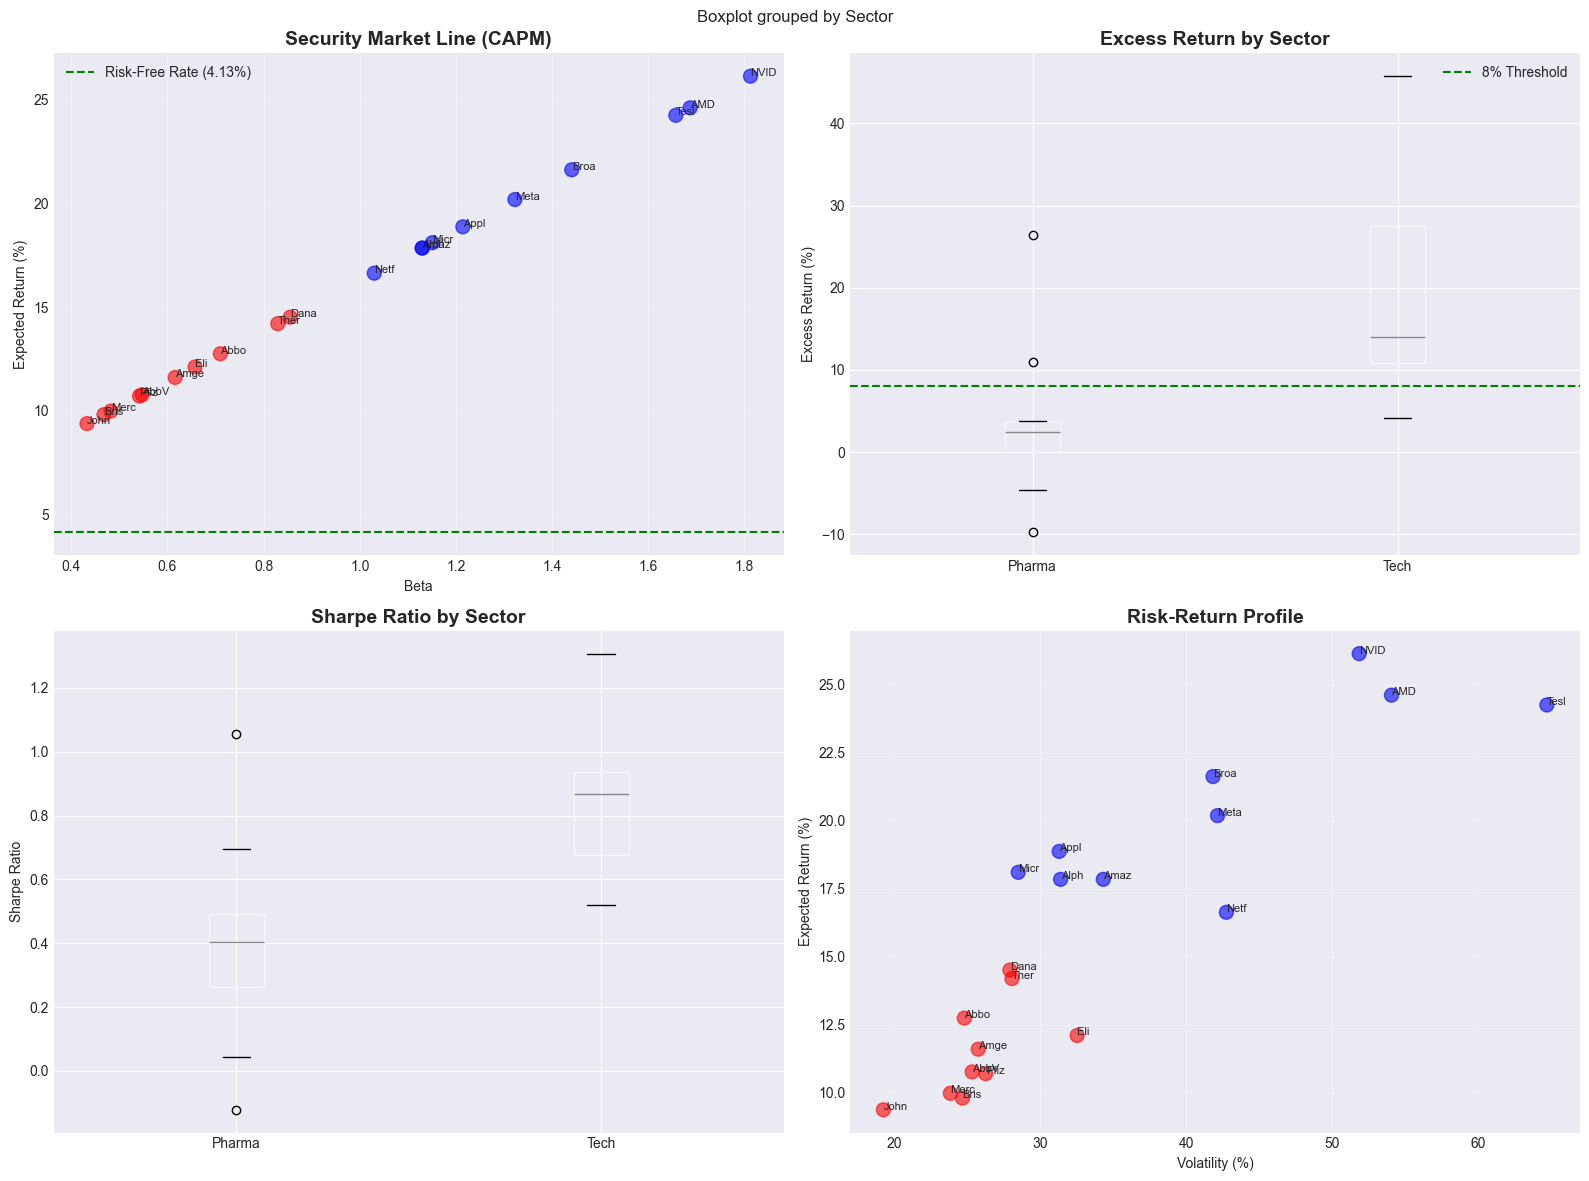

In [12]:
# Visualize CAPM results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Beta vs Expected Return
axes[0, 0].scatter(capm_df['Beta'], capm_df['Expected_Return_%'], 
                   c=['red' if s == 'Pharma' else 'blue' for s in capm_df['Sector']],
                   alpha=0.6, s=100)
for idx in capm_df.index:
    axes[0, 0].annotate(capm_df.loc[idx, 'Name'][:4], 
                       (capm_df.loc[idx, 'Beta'], capm_df.loc[idx, 'Expected_Return_%']),
                       fontsize=8)
axes[0, 0].axhline(y=rf_rate*100, color='green', linestyle='--', label=f'Risk-Free Rate ({rf_rate*100:.2f}%)')
axes[0, 0].set_xlabel('Beta')
axes[0, 0].set_ylabel('Expected Return (%)')
axes[0, 0].set_title('Security Market Line (CAPM)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Excess Return by Sector
if 'Excess_Return_%' in capm_df.columns:
    excess_data = capm_df[['Sector', 'Excess_Return_%']].dropna()
    excess_data.boxplot(column='Excess_Return_%', by='Sector', ax=axes[0, 1])
    axes[0, 1].axhline(y=8, color='green', linestyle='--', label='8% Threshold')
    axes[0, 1].set_title('Excess Return by Sector', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('Excess Return (%)')
    axes[0, 1].legend()

# Sharpe Ratio Comparison
if 'Sharpe_Ratio' in capm_df.columns:
    sharpe_data = capm_df[['Sector', 'Sharpe_Ratio']].dropna()
    sharpe_data.boxplot(column='Sharpe_Ratio', by='Sector', ax=axes[1, 0])
    axes[1, 0].set_title('Sharpe Ratio by Sector', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('')
    axes[1, 0].set_ylabel('Sharpe Ratio')

# Risk-Return Scatter
if 'Volatility_%' in capm_df.columns and 'Expected_Return_%' in capm_df.columns:
    axes[1, 1].scatter(capm_df['Volatility_%'], capm_df['Expected_Return_%'],
                      c=['red' if s == 'Pharma' else 'blue' for s in capm_df['Sector']],
                      alpha=0.6, s=100)
    for idx in capm_df.index:
        axes[1, 1].annotate(capm_df.loc[idx, 'Name'][:4],
                           (capm_df.loc[idx, 'Volatility_%'], capm_df.loc[idx, 'Expected_Return_%']),
                           fontsize=8)
    axes[1, 1].set_xlabel('Volatility (%)')
    axes[1, 1].set_ylabel('Expected Return (%)')
    axes[1, 1].set_title('Risk-Return Profile', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Fama-French Three-Factor Model


In [13]:
# Fama-French factors (using proxies)
# We'll calculate size and value factors from our stock universe

def calculate_fama_french_factors(stock_data, sp500_returns, rf_rate):
    """Calculate Fama-French three-factor model factors"""
    
    # Market factor (excess market return)
    market_factor = sp500_returns - rf_rate/252
    
    # Size factor (SMB - Small Minus Big)
    # Calculate returns for each stock
    stock_returns_dict = {}
    market_caps_dict = {}
    
    for ticker in stock_data.keys():
        stock_hist = stock_data[ticker]['history']
        stock_ret = stock_hist['Close'].pct_change().dropna()
        stock_returns_dict[ticker] = stock_ret
        
        # Get average market cap
        info = stock_data[ticker]['info']
        market_caps_dict[ticker] = info.get('marketCap', 0)
    
    # Split into small and big based on median market cap
    median_mcap = np.median(list(market_caps_dict.values()))
    small_stocks = [t for t, mcap in market_caps_dict.items() if mcap < median_mcap]
    big_stocks = [t for t, mcap in market_caps_dict.items() if mcap >= median_mcap]
    
    # Calculate SMB factor
    small_returns = []
    big_returns = []
    
    for ticker in small_stocks:
        if ticker in stock_returns_dict:
            common_dates = stock_returns_dict[ticker].index.intersection(sp500_returns.index)
            if len(common_dates) > 0:
                small_returns.append(stock_returns_dict[ticker].loc[common_dates])
    
    for ticker in big_stocks:
        if ticker in stock_returns_dict:
            common_dates = stock_returns_dict[ticker].index.intersection(sp500_returns.index)
            if len(common_dates) > 0:
                big_returns.append(stock_returns_dict[ticker].loc[common_dates])
    
    # Value factor (HML - High Minus Low)
    # Use Book-to-Market ratio as proxy
    btms = {}
    for ticker in stock_data.keys():
        info = stock_data[ticker]['info']
        bv = info.get('bookValue', None)
        price = info.get('currentPrice', None)
        if bv and price and price > 0:
            btms[ticker] = bv / price
    
    median_btm = np.median(list(btms.values())) if btms else 0
    high_btm = [t for t, btm in btms.items() if btm >= median_btm] if btms else []
    low_btm = [t for t, btm in btms.items() if btm < median_btm] if btms else []
    
    return {
        'market_factor': market_factor,
        'small_stocks': small_stocks,
        'big_stocks': big_stocks,
        'high_btm': high_btm,
        'low_btm': low_btm,
        'stock_returns': stock_returns_dict
    }

ff_factors = calculate_fama_french_factors(stock_data, sp500_returns, rf_rate)
print("Fama-French factors calculated")
print(f"Small stocks: {len(ff_factors['small_stocks'])}")
print(f"Big stocks: {len(ff_factors['big_stocks'])}")
print(f"High BTM (Value) stocks: {len(ff_factors['high_btm'])}")
print(f"Low BTM (Growth) stocks: {len(ff_factors['low_btm'])}")


Fama-French factors calculated
Small stocks: 10
Big stocks: 10
High BTM (Value) stocks: 10
Low BTM (Growth) stocks: 10


In [14]:
def fama_french_regression(ticker, stock_data, ff_factors, sp500_returns, rf_rate):
    """Run Fama-French three-factor regression"""
    
    if ticker not in stock_data or ticker not in ff_factors['stock_returns']:
        return None
    
    stock_returns = ff_factors['stock_returns'][ticker]
    market_factor = ff_factors['market_factor']
    
    # Align dates
    common_dates = stock_returns.index.intersection(market_factor.index)
    if len(common_dates) < 60:  # Need sufficient data
        return None
    
    stock_ret_aligned = stock_returns.loc[common_dates]
    market_factor_aligned = market_factor.loc[common_dates]
    
    # Calculate SMB factor (simplified - average small minus average big)
    small_avg_ret = []
    big_avg_ret = []
    
    for t in ff_factors['small_stocks']:
        if t in ff_factors['stock_returns']:
            ret = ff_factors['stock_returns'][t]
            aligned = ret.index.intersection(common_dates)
            if len(aligned) > 0:
                small_avg_ret.append(ret.loc[aligned])
    
    for t in ff_factors['big_stocks']:
        if t in ff_factors['stock_returns']:
            ret = ff_factors['stock_returns'][t]
            aligned = ret.index.intersection(common_dates)
            if len(aligned) > 0:
                big_avg_ret.append(ret.loc[aligned])
    
    if not small_avg_ret or not big_avg_ret:
        return None
    
    # Average small and big returns
    small_portfolio = pd.Series(0, index=common_dates)
    for ret_series in small_avg_ret:
        common = ret_series.index.intersection(common_dates)
        if len(common) > 0:
            small_portfolio.loc[common] += ret_series.loc[common]
    small_portfolio = small_portfolio / len(small_avg_ret) - rf_rate/252
    
    big_portfolio = pd.Series(0, index=common_dates)
    for ret_series in big_avg_ret:
        common = ret_series.index.intersection(common_dates)
        if len(common) > 0:
            big_portfolio.loc[common] += ret_series.loc[common]
    big_portfolio = big_portfolio / len(big_avg_ret) - rf_rate/252
    
    smb_factor = small_portfolio - big_portfolio
    
    # Calculate HML factor (simplified)
    high_btm_ret = []
    low_btm_ret = []
    
    for t in ff_factors['high_btm']:
        if t in ff_factors['stock_returns']:
            ret = ff_factors['stock_returns'][t]
            aligned = ret.index.intersection(common_dates)
            if len(aligned) > 0:
                high_btm_ret.append(ret.loc[aligned])
    
    for t in ff_factors['low_btm']:
        if t in ff_factors['stock_returns']:
            ret = ff_factors['stock_returns'][t]
            aligned = ret.index.intersection(common_dates)
            if len(aligned) > 0:
                low_btm_ret.append(ret.loc[aligned])
    
    if not high_btm_ret or not low_btm_ret:
        hml_factor = pd.Series(0, index=common_dates)
    else:
        high_portfolio = pd.Series(0, index=common_dates)
        for ret_series in high_btm_ret:
            common = ret_series.index.intersection(common_dates)
            if len(common) > 0:
                high_portfolio.loc[common] += ret_series.loc[common]
        high_portfolio = high_portfolio / len(high_btm_ret) - rf_rate/252
        
        low_portfolio = pd.Series(0, index=common_dates)
        for ret_series in low_btm_ret:
            common = ret_series.index.intersection(common_dates)
            if len(common) > 0:
                low_portfolio.loc[common] += ret_series.loc[common]
        low_portfolio = low_portfolio / len(low_btm_ret) - rf_rate/252
        
        hml_factor = high_portfolio - low_portfolio
    
    # Prepare factors for regression
    stock_excess_ret = stock_ret_aligned - rf_rate/252
    
    # Align all factors
    factors_df = pd.DataFrame({
        'Market': market_factor_aligned,
        'SMB': smb_factor.loc[common_dates],
        'HML': hml_factor.loc[common_dates]
    }).dropna()
    
    if len(factors_df) < 30:
        return None
    
    stock_ret_aligned_ff = stock_excess_ret.loc[factors_df.index]
    
    # Run regression
    X = sm.add_constant(factors_df[['Market', 'SMB', 'HML']])
    y = stock_ret_aligned_ff
    
    model = sm.OLS(y, X).fit()
    
    # Annualize coefficients
    alpha_annual = model.params[0] * 252 * 100
    beta_market = model.params[1]
    beta_smb = model.params[2]
    beta_hml = model.params[3]
    
    return {
        'Alpha_%': alpha_annual,
        'Beta_Market': beta_market,
        'Beta_SMB': beta_smb,
        'Beta_HML': beta_hml,
        'R_Squared': model.rsquared,
        'P_Value_Alpha': model.pvalues[0]
    }

# Run Fama-French regression for all stocks
ff_results = {}
for ticker in stock_data.keys():
    ff_result = fama_french_regression(ticker, stock_data, ff_factors, sp500_returns, rf_rate)
    if ff_result:
        ff_results[ticker] = ff_result

ff_df = pd.DataFrame(ff_results).T
ff_df['Name'] = metrics_df.loc[ff_df.index, 'name']
ff_df['Sector'] = metrics_df.loc[ff_df.index, 'sector']

print("\n=== Fama-French Three-Factor Model Results ===\n")
display_cols = ['Name', 'Sector', 'Alpha_%', 'Beta_Market', 'Beta_SMB', 'Beta_HML', 'R_Squared']
display_cols = [col for col in display_cols if col in ff_df.columns]
print(ff_df[display_cols].round(3))

# Identify stocks with positive alpha (undervalued)
positive_alpha = ff_df[ff_df['Alpha_%'] > 0].copy()
print("\n=== Stocks with Positive Alpha (Fama-French) ===\n")
if len(positive_alpha) > 0:
    print(positive_alpha[display_cols].sort_values('Alpha_%', ascending=False).round(3))
else:
    print("No stocks with positive alpha found")



=== Fama-French Three-Factor Model Results ===

                           Name  Sector  Alpha_%  Beta_Market  Beta_SMB  \
JNJ           Johnson & Johnson  Pharma    9.276        0.710     0.623   
PFE                      Pfizer  Pharma    0.976        0.882     0.626   
MRK                 Merck & Co.  Pharma    8.253        0.790     0.662   
ABBV                     AbbVie  Pharma   15.583        0.887     1.180   
TMO    Thermo Fisher Scientific  Pharma   13.541        1.057     0.192   
ABT         Abbott Laboratories  Pharma    9.406        0.957     0.423   
DHR         Danaher Corporation  Pharma   11.980        1.067     0.184   
LLY                   Eli Lilly  Pharma   26.989        0.806     0.644   
BMY        Bristol-Myers Squibb  Pharma    4.765        0.788     0.655   
AMGN                      Amgen  Pharma    7.288        0.936     1.127   
AAPL                      Apple    Tech    9.307        1.095    -0.080   
MSFT                  Microsoft    Tech    5.243   

## 6. Scenario-Based Valuations


In [15]:
def scenario_valuation(ticker, metrics_df, comps_summary):
    """Calculate price targets under different scenarios"""
    
    if ticker not in metrics_df.index or ticker not in comps_price_targets:
        return None
    
    company_data = metrics_df.loc[ticker]
    sector = company_data['sector']
    
    # Get sector comps
    if sector == 'Pharma':
        comps = calculate_comps_valuation(metrics_df, sector='Pharma')
    else:
        comps = calculate_comps_valuation(metrics_df, sector='Tech')
    
    # Get RIM valuation if available
    rim_value = None
    if ticker in rim_valuations:
        rim_value = rim_valuations[ticker]['Intrinsic_Value']
    
    # Get current comps targets
    comps_targets = comps_price_targets[ticker]
    base_price = company_data['current_price']
    
    # Scenario 1: Bull Case (Upper quartile multiples)
    bull_targets = apply_comps_valuation(ticker, metrics_df, comps_multiple='max', sector_filter=True)
    if bull_targets:
        bull_avg = np.mean(list(bull_targets.values()))
    else:
        bull_avg = base_price * 1.25  # 25% upside assumption
    
    # Scenario 2: Base Case (Median multiples)
    base_targets = apply_comps_valuation(ticker, metrics_df, comps_multiple='median', sector_filter=True)
    if base_targets:
        base_avg = np.mean(list(base_targets.values()))
    else:
        base_avg = base_price
    
    # Scenario 3: Bear Case (Lower quartile multiples)
    bear_targets = apply_comps_valuation(ticker, metrics_df, comps_multiple='min', sector_filter=True)
    if bear_targets:
        bear_avg = np.mean(list(bear_targets.values()))
    else:
        bear_avg = base_price * 0.85  # 15% downside assumption
    
    # Weighted average using RIM if available
    if rim_value:
        scenarios = {
            'Bull': (bull_avg * 0.3 + rim_value * 0.7),
            'Base': (base_avg * 0.5 + rim_value * 0.5),
            'Bear': (bear_avg * 0.7 + rim_value * 0.3)
        }
    else:
        scenarios = {
            'Bull': bull_avg,
            'Base': base_avg,
            'Bear': bear_avg
        }
    
    # Calculate probability-weighted expected value (assuming 30% bull, 50% base, 20% bear)
    expected_value = scenarios['Bull'] * 0.3 + scenarios['Base'] * 0.5 + scenarios['Bear'] * 0.2
    
    return {
        'Bull_Target': scenarios['Bull'],
        'Base_Target': scenarios['Base'],
        'Bear_Target': scenarios['Bear'],
        'Expected_Target': expected_value,
        'Current_Price': base_price,
        'Bull_Upside_%': ((scenarios['Bull'] - base_price) / base_price) * 100,
        'Base_Upside_%': ((scenarios['Base'] - base_price) / base_price) * 100,
        'Bear_Upside_%': ((scenarios['Bear'] - base_price) / base_price) * 100,
        'Expected_Upside_%': ((expected_value - base_price) / base_price) * 100,
        'RIM_Value': rim_value
    }

# Calculate scenario valuations
scenario_valuations = {}
for ticker in metrics_df.index:
    scenario_val = scenario_valuation(ticker, metrics_df, None)
    if scenario_val:
        scenario_valuations[ticker] = scenario_val

scenario_df = pd.DataFrame(scenario_valuations).T
scenario_df['Name'] = metrics_df.loc[scenario_df.index, 'name']
scenario_df['Sector'] = metrics_df.loc[scenario_df.index, 'sector']

print("\n=== Scenario-Based Valuations ===\n")
display_cols = ['Name', 'Sector', 'Current_Price', 'Bear_Target', 'Base_Target', 
                'Bull_Target', 'Expected_Target', 'Expected_Upside_%']
display_cols = [col for col in display_cols if col in scenario_df.columns]
print(scenario_df[display_cols].round(2))

# Identify best opportunities
best_opportunities = scenario_df[scenario_df['Expected_Upside_%'] > 8].copy()
print("\n=== Best Investment Opportunities (Expected Upside > 8%) ===\n")
if len(best_opportunities) > 0:
    print(best_opportunities[display_cols].sort_values('Expected_Upside_%', ascending=False).round(2))
else:
    print("No stocks meet the >8% expected upside criteria")



=== Scenario-Based Valuations ===

                           Name  Sector  Current_Price  Bear_Target  \
JNJ           Johnson & Johnson  Pharma         200.00        81.36   
PFE                      Pfizer  Pharma          25.45        23.54   
MRK                 Merck & Co.  Pharma          96.43        66.65   
ABBV                     AbbVie  Pharma         233.87        66.78   
TMO    Thermo Fisher Scientific  Pharma         576.03       189.97   
ABT         Abbott Laboratories  Pharma         130.00        49.38   
DHR         Danaher Corporation  Pharma         225.51        75.95   
LLY                   Eli Lilly  Pharma        1030.05       151.80   
BMY        Bristol-Myers Squibb  Pharma          47.06        45.62   
AMGN                      Amgen  Pharma         343.99       118.53   
AAPL                      Apple    Tech         267.44        81.93   
MSFT                  Microsoft    Tech         493.79       158.91   
GOOGL                  Alphabet    Tech  

## 7. Portfolio Stress Testing Dashboard


In [16]:
def portfolio_stress_test(portfolio_weights, stock_data, metrics_df, capm_df, 
                          rate_shock=0.01, earnings_shock=0.1, scenarios=['Base', 'Rate_Up', 'Rate_Down', 'Earnings_Up', 'Earnings_Down']):
    """
    Stress test portfolio under different scenarios:
    - Rate shocks (interest rate changes)
    - Earnings shocks (earnings growth changes)
    """
    
    results = {}
    
    for scenario in scenarios:
        scenario_results = {
            'Portfolio_Return_%': 0,
            'Portfolio_Volatility_%': 0,
            'Portfolio_Value_Change_%': 0,
            'Max_Drawdown_%': 0,
            'Sharpe_Ratio': 0
        }
        
        portfolio_return = 0
        portfolio_beta = 0
        total_weight = 0
        
        for ticker, weight in portfolio_weights.items():
            if ticker not in capm_df.index or ticker not in metrics_df.index:
                continue
            
            total_weight += weight
            
            # Get base metrics
            expected_return = capm_df.loc[ticker, 'Expected_Return_%'] / 100
            beta = capm_df.loc[ticker, 'Beta']
            volatility = capm_df.loc[ticker, 'Volatility_%'] / 100
            current_price = metrics_df.loc[ticker, 'current_price']
            
            # Apply scenario shocks
            if scenario == 'Rate_Up':
                # Interest rates up: lower valuations, higher required returns
                expected_return += beta * rate_shock
                price_impact = -beta * rate_shock * 100  # Approximate price impact
                scenario_return = expected_return
            elif scenario == 'Rate_Down':
                # Interest rates down: higher valuations, lower required returns
                expected_return -= beta * rate_shock
                price_impact = beta * rate_shock * 100
                scenario_return = expected_return
            elif scenario == 'Earnings_Up':
                # Earnings surprise positive: higher returns
                scenario_return = expected_return + earnings_shock
                price_impact = earnings_shock * 100
            elif scenario == 'Earnings_Down':
                # Earnings miss: lower returns
                scenario_return = expected_return - earnings_shock
                price_impact = -earnings_shock * 100
            else:  # Base case
                scenario_return = expected_return
                price_impact = 0
            
            # Add to portfolio
            portfolio_return += weight * scenario_return
            portfolio_beta += weight * beta
        
        # Normalize weights
        if total_weight > 0:
            portfolio_return = portfolio_return / total_weight
            portfolio_beta = portfolio_beta / total_weight
        
        # Calculate portfolio volatility (simplified)
        # Assume correlation of 0.5 between assets for simplicity
        portfolio_variance = 0
        for ticker1, weight1 in portfolio_weights.items():
            if ticker1 not in capm_df.index:
                continue
            vol1 = capm_df.loc[ticker1, 'Volatility_%'] / 100
            portfolio_variance += (weight1 / total_weight) ** 2 * vol1 ** 2
            
            for ticker2, weight2 in portfolio_weights.items():
                if ticker2 not in capm_df.index or ticker1 == ticker2:
                    continue
                vol2 = capm_df.loc[ticker2, 'Volatility_%'] / 100
                portfolio_variance += (weight1 / total_weight) * (weight2 / total_weight) * vol1 * vol2 * 0.5
        
        portfolio_volatility = np.sqrt(portfolio_variance)
        
        # Calculate portfolio metrics
        scenario_results['Portfolio_Return_%'] = portfolio_return * 100
        scenario_results['Portfolio_Volatility_%'] = portfolio_volatility * 100
        scenario_results['Portfolio_Value_Change_%'] = portfolio_return * 100  # Assuming 1-year horizon
        scenario_results['Sharpe_Ratio'] = (portfolio_return - rf_rate) / portfolio_volatility if portfolio_volatility > 0 else 0
        scenario_results['Portfolio_Beta'] = portfolio_beta
        scenario_results['Max_Drawdown_%'] = -portfolio_volatility * 2.33  # Approximate 1% VaR (99% confidence)
        
        results[scenario] = scenario_results
    
    return pd.DataFrame(results).T

# Example: Create an equal-weighted portfolio of top opportunities
top_stocks = scenario_df.nlargest(5, 'Expected_Upside_%').index
portfolio_weights = {ticker: 1/len(top_stocks) for ticker in top_stocks}

print(f"Portfolio: Equal-weighted in top 5 opportunities")
for ticker in top_stocks:
    print(f"  {metrics_df.loc[ticker, 'name']} ({ticker}): {portfolio_weights[ticker]*100:.1f}%")

# Run stress test
stress_results = portfolio_stress_test(portfolio_weights, stock_data, metrics_df, capm_df)

print("\n=== Portfolio Stress Test Results ===\n")
print(stress_results.round(2))


Portfolio: Equal-weighted in top 5 opportunities
  Netflix (NFLX): 20.0%
  Bristol-Myers Squibb (BMY): 20.0%
  Pfizer (PFE): 20.0%
  Merck & Co. (MRK): 20.0%
  Alphabet (GOOGL): 20.0%

=== Portfolio Stress Test Results ===

               Portfolio_Return_%  Portfolio_Volatility_%  \
Base                        13.00                   23.18   
Rate_Up                     13.73                   23.18   
Rate_Down                   12.27                   23.18   
Earnings_Up                 23.00                   23.18   
Earnings_Down                3.00                   23.18   

               Portfolio_Value_Change_%  Max_Drawdown_%  Sharpe_Ratio  \
Base                              13.00           -0.54          0.38   
Rate_Up                           13.73           -0.54          0.41   
Rate_Down                         12.27           -0.54          0.35   
Earnings_Up                       23.00           -0.54          0.81   
Earnings_Down                      3.00     

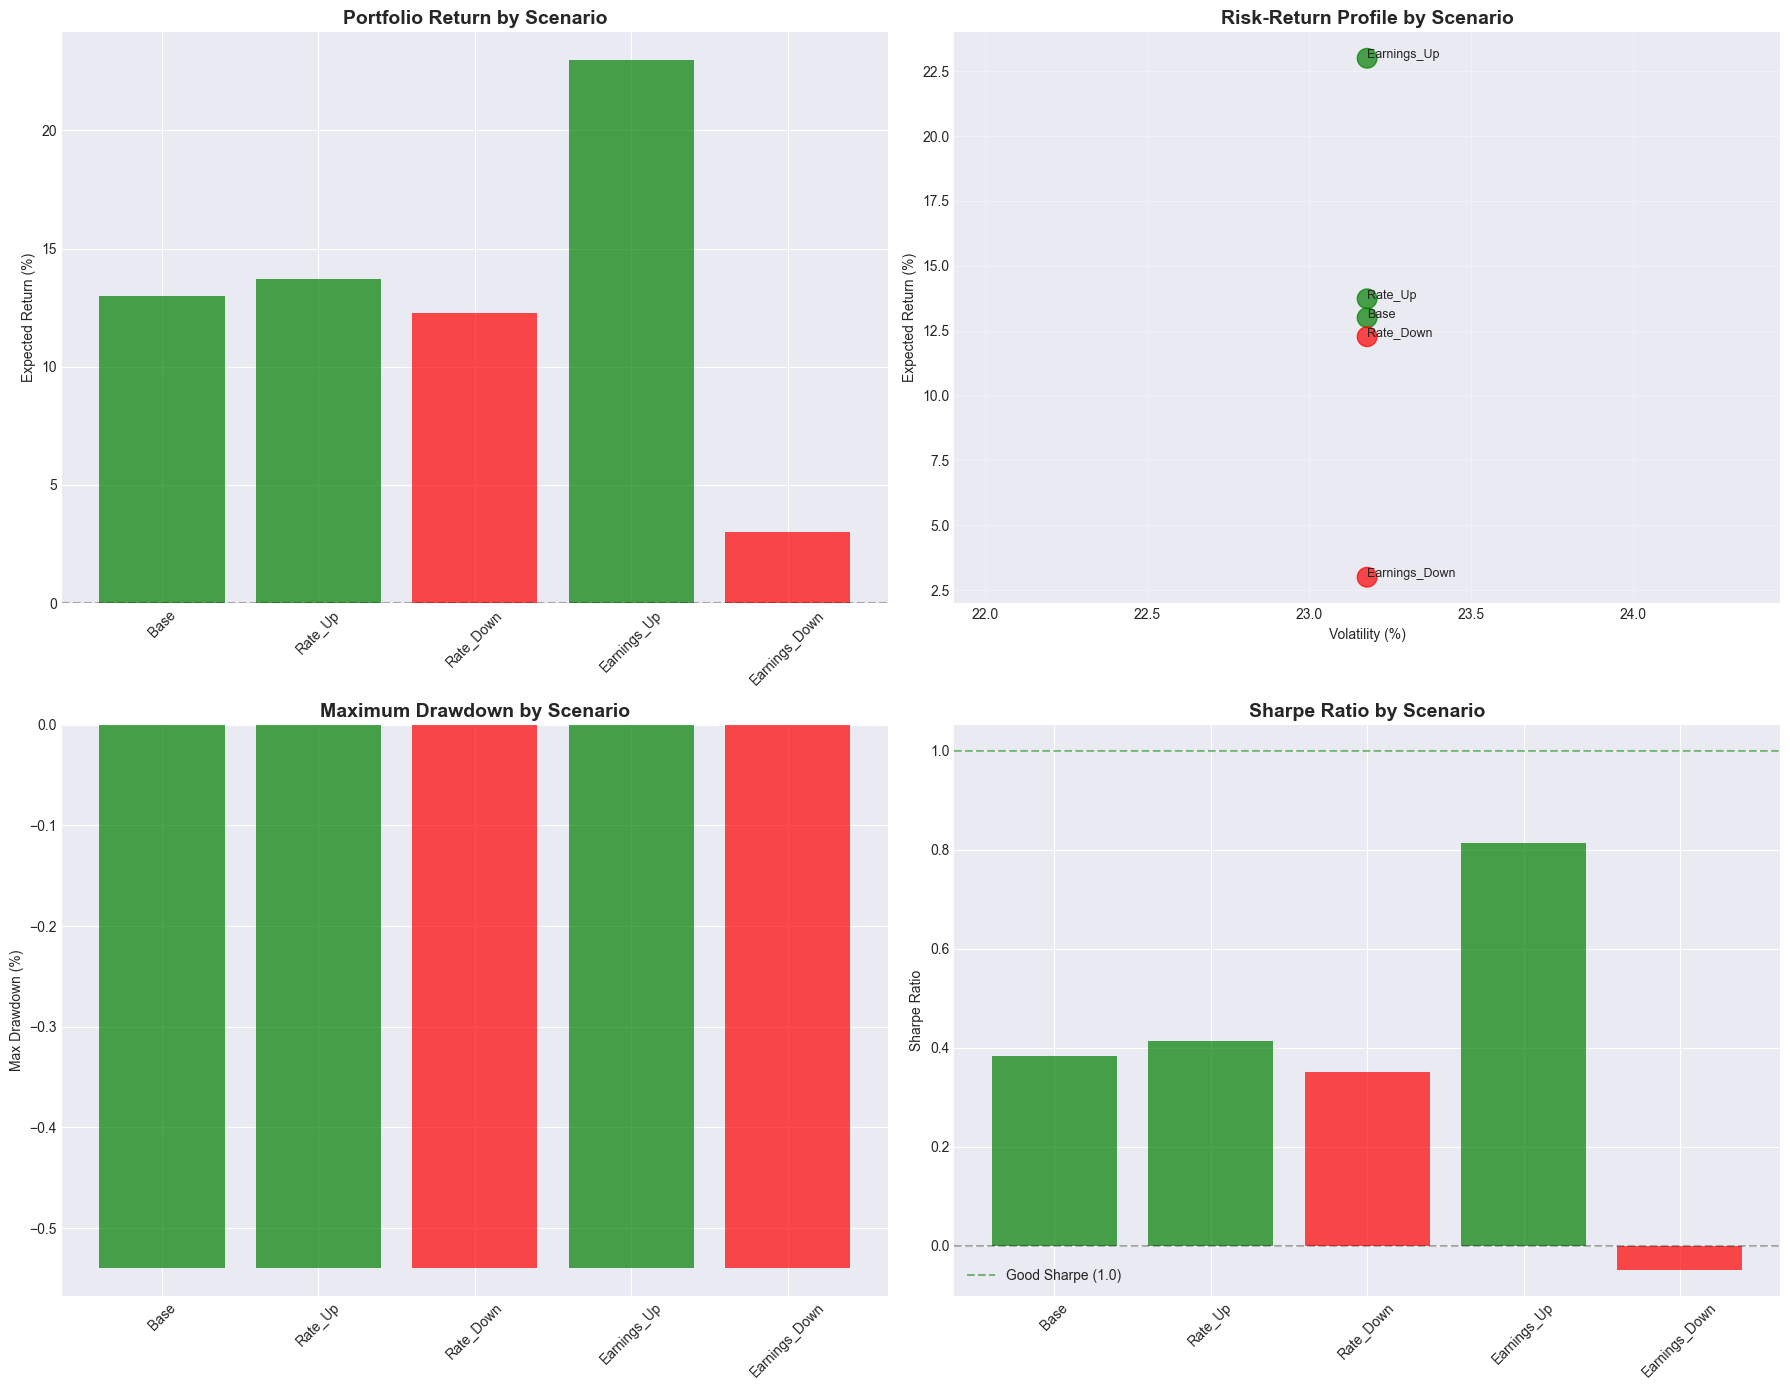


=== Portfolio Stress Test Summary ===

Base Case Return: 13.00%
Best Case Return: 23.00% (Earnings_Up)
Worst Case Return: 3.00% (Earnings_Down)
Average Volatility: 23.18%
Average Sharpe Ratio: 0.38


In [17]:
# Create interactive dashboard visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Scenario Returns Comparison
scenario_names = stress_results.index
returns = stress_results['Portfolio_Return_%']
colors = ['green' if 'Up' in s or s == 'Base' else 'red' if 'Down' in s else 'blue' for s in scenario_names]
axes[0, 0].bar(scenario_names, returns, color=colors, alpha=0.7)
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[0, 0].set_title('Portfolio Return by Scenario', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Expected Return (%)')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Risk-Return Scatter
axes[0, 1].scatter(stress_results['Portfolio_Volatility_%'], stress_results['Portfolio_Return_%'],
                   s=200, c=colors, alpha=0.7)
for idx, scenario in enumerate(scenario_names):
    axes[0, 1].annotate(scenario, 
                       (stress_results.loc[scenario, 'Portfolio_Volatility_%'],
                        stress_results.loc[scenario, 'Portfolio_Return_%']),
                       fontsize=9)
axes[0, 1].set_xlabel('Volatility (%)')
axes[0, 1].set_ylabel('Expected Return (%)')
axes[0, 1].set_title('Risk-Return Profile by Scenario', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Max Drawdown Comparison
axes[1, 0].bar(scenario_names, stress_results['Max_Drawdown_%'], color=colors, alpha=0.7)
axes[1, 0].set_title('Maximum Drawdown by Scenario', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Max Drawdown (%)')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Sharpe Ratio Comparison
axes[1, 1].bar(scenario_names, stress_results['Sharpe_Ratio'], color=colors, alpha=0.7)
axes[1, 1].axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Good Sharpe (1.0)')
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1, 1].set_title('Sharpe Ratio by Scenario', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Sharpe Ratio')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== Portfolio Stress Test Summary ===\n")
print(f"Base Case Return: {stress_results.loc['Base', 'Portfolio_Return_%']:.2f}%")
print(f"Best Case Return: {stress_results['Portfolio_Return_%'].max():.2f}% ({stress_results['Portfolio_Return_%'].idxmax()})")
print(f"Worst Case Return: {stress_results['Portfolio_Return_%'].min():.2f}% ({stress_results['Portfolio_Return_%'].idxmin()})")
print(f"Average Volatility: {stress_results['Portfolio_Volatility_%'].mean():.2f}%")
print(f"Average Sharpe Ratio: {stress_results['Sharpe_Ratio'].mean():.2f}")


## 8. Comprehensive Investment Summary


In [18]:
# Combine all analyses into comprehensive summary
summary_df = metrics_df[['name', 'sector', 'current_price']].copy()

# Add CAPM results
if 'Excess_Return_%' in capm_df.columns:
    summary_df['CAPM_Excess_Return_%'] = capm_df['Excess_Return_%']
    summary_df['CAPM_Alpha_%'] = capm_df['Alpha_Annual_%']
    summary_df['Beta'] = capm_df['Beta']
    summary_df['Sharpe_Ratio'] = capm_df['Sharpe_Ratio']

# Add Fama-French results
if 'Alpha_%' in ff_df.columns:
    summary_df['FF_Alpha_%'] = ff_df['Alpha_%']

# Add scenario valuations
if 'Expected_Target' in scenario_df.columns:
    summary_df['Expected_Price_Target'] = scenario_df['Expected_Target']
    summary_df['Expected_Upside_%'] = scenario_df['Expected_Upside_%']
    summary_df['Bull_Target'] = scenario_df['Bull_Target']
    summary_df['Bear_Target'] = scenario_df['Bear_Target']

# Add RIM valuations
if rim_summary is not None and 'Intrinsic_Value' in rim_summary.columns:
    summary_df['RIM_Intrinsic_Value'] = rim_summary['Intrinsic_Value']
    summary_df['RIM_Upside_%'] = rim_summary['Upside_%']

# Calculate composite score (weighted average of different signals)
summary_df['Composite_Score'] = 0

# Normalize and weight different signals
if 'CAPM_Excess_Return_%' in summary_df.columns:
    summary_df['CAPM_Score'] = summary_df['CAPM_Excess_Return_%'].fillna(0) / summary_df['CAPM_Excess_Return_%'].abs().max() * 0.3
    summary_df['Composite_Score'] += summary_df['CAPM_Score']

if 'FF_Alpha_%' in summary_df.columns:
    summary_df['FF_Score'] = summary_df['FF_Alpha_%'].fillna(0) / summary_df['FF_Alpha_%'].abs().max() * 0.3
    summary_df['Composite_Score'] += summary_df['FF_Score']

if 'Expected_Upside_%' in summary_df.columns:
    summary_df['Valuation_Score'] = summary_df['Expected_Upside_%'].fillna(0) / summary_df['Expected_Upside_%'].abs().max() * 0.4
    summary_df['Composite_Score'] += summary_df['Valuation_Score']

# Identify top investment opportunities
summary_df = summary_df.sort_values('Composite_Score', ascending=False, na_position='last')

print("\n" + "="*100)
print("COMPREHENSIVE INVESTMENT SUMMARY")
print("="*100)

print("\n=== Top 10 Investment Opportunities ===\n")
top_opportunities = summary_df.head(10)
display_cols = ['name', 'sector', 'current_price', 'Expected_Price_Target', 'Expected_Upside_%',
                'CAPM_Excess_Return_%', 'FF_Alpha_%', 'Composite_Score']
display_cols = [col for col in display_cols if col in top_opportunities.columns]
print(top_opportunities[display_cols].round(2))

# Export to Excel for further analysis
output_file = 'equity_research_summary.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    summary_df.to_excel(writer, sheet_name='Summary', index=True)
    if capm_df is not None:
        capm_df.to_excel(writer, sheet_name='CAPM_Analysis', index=True)
    if ff_df is not None:
        ff_df.to_excel(writer, sheet_name='FamaFrench_Analysis', index=True)
    if scenario_df is not None:
        scenario_df.to_excel(writer, sheet_name='Scenario_Valuations', index=True)
    stress_results.to_excel(writer, sheet_name='Stress_Test', index=True)

print(f"\n✓ Results exported to {output_file}")
print("\n" + "="*100)



COMPREHENSIVE INVESTMENT SUMMARY

=== Top 10 Investment Opportunities ===

                       name  sector current_price  Expected_Price_Target  \
NVDA                 NVIDIA    Tech        181.36                  93.84   
NFLX                Netflix    Tech        114.09                 352.22   
AVGO               Broadcom    Tech         340.5                 274.34   
AMD                     AMD    Tech        230.29                 145.07   
LLY               Eli Lilly  Pharma       1030.05                 337.25   
BMY    Bristol-Myers Squibb  Pharma         47.06                 105.01   
TSLA                  Tesla    Tech        401.25                 126.60   
GOOGL              Alphabet    Tech        284.28                 408.84   
MRK             Merck & Co.  Pharma         96.43                 143.49   
ABBV                 AbbVie  Pharma        233.87                 163.77   

       Expected_Upside_%  CAPM_Excess_Return_%  FF_Alpha_%  Composite_Score  
NVDA     